# **CUSTOM INDIAN SIGN LANGUAGE DATASET**

# LIBRARIES

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Image processing libraries
import cv2
import skimage
from skimage.transform import resize

# Scikit-learn for machine learning operations
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow import keras
from keras import utils, callbacks
from tensorflow.keras import utils
from tensorflow.keras import layers, models
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Metrics for evaluation
from sklearn import metrics

# DATA LOADING AND PREPROCESSING

In [ ]:
#Load the Dataset
import os
dataset_path = "/content/new_isl_dataset"
total_signs = sorted(os.listdir(dataset_path))
print(total_signs)

['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [ ]:
import os
from collections import defaultdict
from matplotlib.image import imread

path = "/content/new_isl_dataset"
total_signs = os.listdir(path)

resolution_count = defaultdict(int)

for directory in total_signs:
    directory_path = os.path.join(path, directory)
    for filename in os.listdir(directory_path):
        image_path = os.path.join(directory_path, filename)
        try:
            img = imread(image_path)
            resolution = img.shape[:2]  # Extract resolution (height, width)
            resolution_count[resolution] += 1
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

print("Resolution Counts:")
for resolution, count in resolution_count.items():
    print(f"Resolution: {resolution}, Count: {count}")


Resolution Counts:
Resolution: (256, 256), Count: 17500


In [ ]:
train_folder = '/content/new_isl_dataset'

# Constructing a list of dictionaries containing file paths and corresponding labels
all_data = [{'label': folder, 'path': os.path.join(train_folder, folder, f)}
            for folder in os.listdir(train_folder)
            for f in os.listdir(os.path.join(train_folder, folder))
            if os.path.isfile(os.path.join(train_folder, folder, f))]

# Creating a DataFrame from the list of dictionaries
data_df = pd.DataFrame(all_data)
data_df

,label,path
0,P,/content/new_isl_dataset/P/20240329_140755_019...
1,P,/content/new_isl_dataset/P/20240329_140520_014...
2,P,/content/new_isl_dataset/P/20240329_140417_025...
3,P,/content/new_isl_dataset/P/20240329_140339_025...
4,P,/content/new_isl_dataset/P/20240329_140520_006...
...,...,...
17495,F,/content/new_isl_dataset/F/IMG_20240328_160906...
17496,F,/content/new_isl_dataset/F/IMG_20240328_160604...
17497,F,/content/new_isl_dataset/F/IMG_20240328_161344...
17498,F,/content/new_isl_dataset/F/IMG_20240328_161331...


In [ ]:
train_data, test_data = train_test_split(data_df, test_size=0.1, random_state=42, stratify=data_df['label'])
train_data, validation_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['label'])

# Display the number of samples in each set
print("Training samples:", len(train_data))
print("Validation samples:", len(validation_data))
print("Test samples:", len(test_data))

Training samples: 12600
Validation samples: 3150
Test samples: 1750


In [ ]:
# Displaying the dimensions
print("Training data shape:", train_data.shape)
print("Validation data shape:", validation_data.shape)
print("Test data shape:", test_data.shape)

Training data shape: (12600, 2)
Validation data shape: (3150, 2)
Test data shape: (1750, 2)


In [ ]:
# Define image dimensions and batch size
img_width, img_height = 128, 128
batch_size = 32

# Define column names
y_col = 'label'
x_col = 'path'

# Number of classes
no_of_classes = len(data_df[y_col].unique())

# Image data generators
datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='path',
    y_col='label',
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=validation_data,
    x_col='path',
    y_col='label',
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='path',
    y_col='label',
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 12600 validated image filenames belonging to 35 classes.
Found 3150 validated image filenames belonging to 35 classes.
Found 1750 validated image filenames belonging to 35 classes.


# CUSTOM-CNN

In [ ]:
Early_Stopper = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")
Checkpoint_Model = tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      filepath="./modelcheck")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

cnn_model = Sequential()

cnn_model.add(Conv2D(24,(3,3),activation="relu",input_shape=(img_width, img_height, 3)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2,2),strides=2))

cnn_model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
cnn_model.add(Dropout(0.3))
cnn_model.add(MaxPooling2D((2,2),strides=2))

cnn_model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
cnn_model.add(Dropout(0.3))
cnn_model.add(MaxPooling2D((2,2),strides=2))

cnn_model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
cnn_model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
cnn_model.add(Dropout(0.3))
cnn_model.add(MaxPooling2D((2,2),strides=2))

cnn_model.add(Conv2D(256,(3,3),activation="relu",padding="same"))
cnn_model.add(Dropout(0.3))
cnn_model.add(MaxPooling2D((2,2),strides=2))

cnn_model.add(Flatten())
cnn_model.add(Dense(2352,activation="relu"))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(35,activation="softmax"))


In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 24)      672       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 24)      96        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 24)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        13888     
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 64)        0

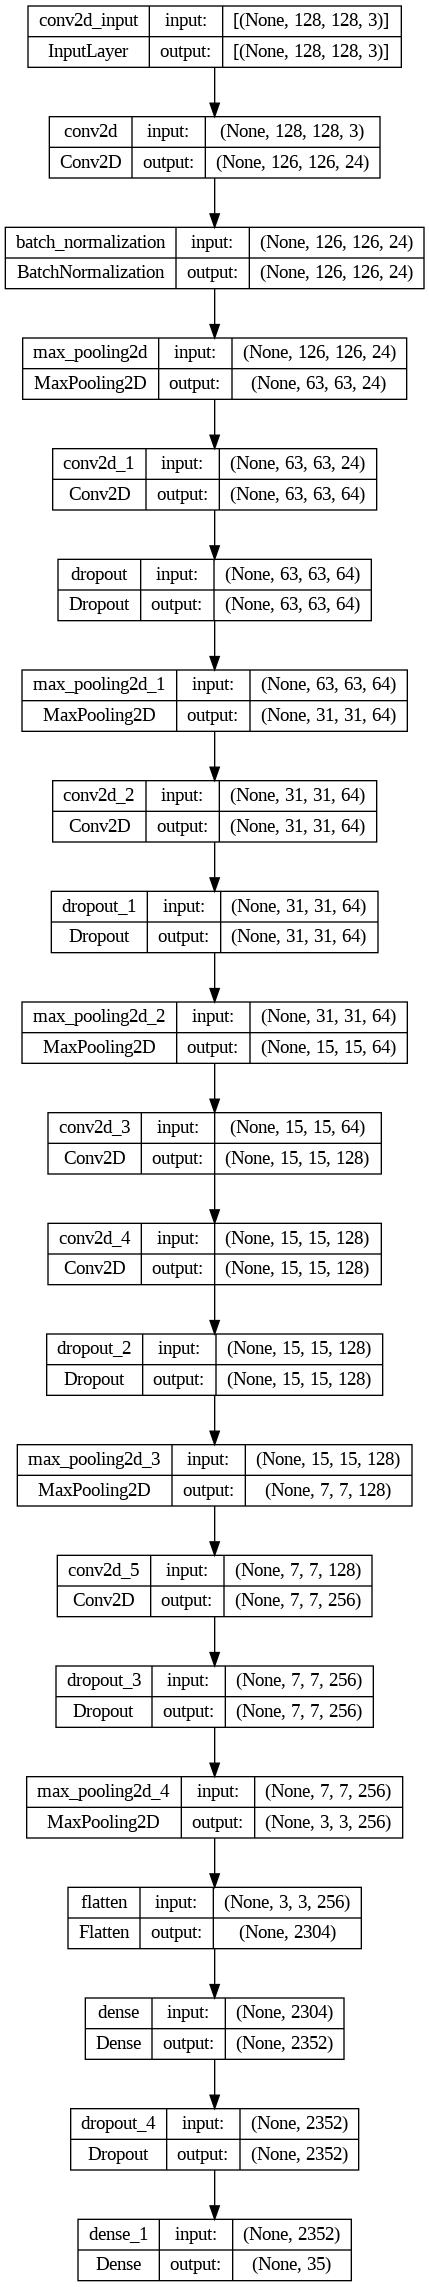

In [ ]:
!pip install pydot graphviz
from tensorflow.keras.utils import plot_model

# Plot the model
plot_model(cnn_model, to_file='custom_cnn_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Define parameters
learning_rate = 0.0001

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = cnn_model.fit(train_generator,
                    epochs=10,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[Early_Stopper,Checkpoint_Model],
                    shuffle=True)


Epoch 1/10
394/394 [==============================] - 40s 98ms/step - loss: 0.1300 - accuracy: 0.9551 - val_loss: 0.2471 - val_accuracy: 0.9790
Epoch 2/10
394/394 [==============================] - 41s 103ms/step - loss: 0.1138 - accuracy: 0.9607 - val_loss: 0.2258 - val_accuracy: 0.9806
Epoch 3/10
394/394 [==============================] - 40s 103ms/step - loss: 0.1041 - accuracy: 0.9633 - val_loss: 0.1902 - val_accuracy: 0.9857
Epoch 4/10
394/394 [==============================] - 40s 103ms/step - loss: 0.0872 - accuracy: 0.9717 - val_loss: 0.2075 - val_accuracy: 0.9790
Epoch 5/10
394/394 [==============================] - 40s 102ms/step - loss: 0.0809 - accuracy: 0.9733 - val_loss: 0.1928 - val_accuracy: 0.9835
Epoch 6/10
394/394 [==============================] - 40s 103ms/step - loss: 0.0743 - accuracy: 0.9734 - val_loss: 0.1379 - val_accuracy: 0.9895
Epoch 7/10
394/394 [==============================] - 40s 101ms/step - loss: 0.0777 - accuracy: 0.9744 - val_loss: 0.1660 - val_acc

In [ ]:
cnn_model.save('custom-cnn-newisl.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


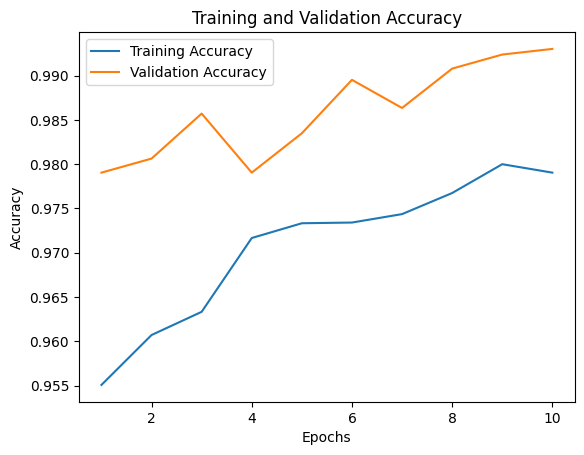

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy and loss from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


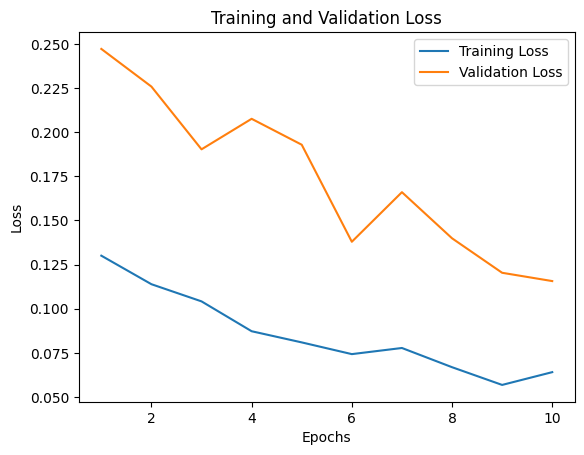

In [ ]:

# Plot training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score

# Generate predictions on test data
predictions = cnn_model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels back to categorical labels
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes) * 100
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted') * 100
recall = recall_score(true_classes, predicted_classes, average='weighted') * 100
f1_score = 2 * (precision * recall) / (precision + recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


55/55 [==============================] - 1s 16ms/step
Accuracy: 99.94285714285715
Precision: 99.94397759103641
Recall: 99.94285714285715
F1-score: 99.94341736380649


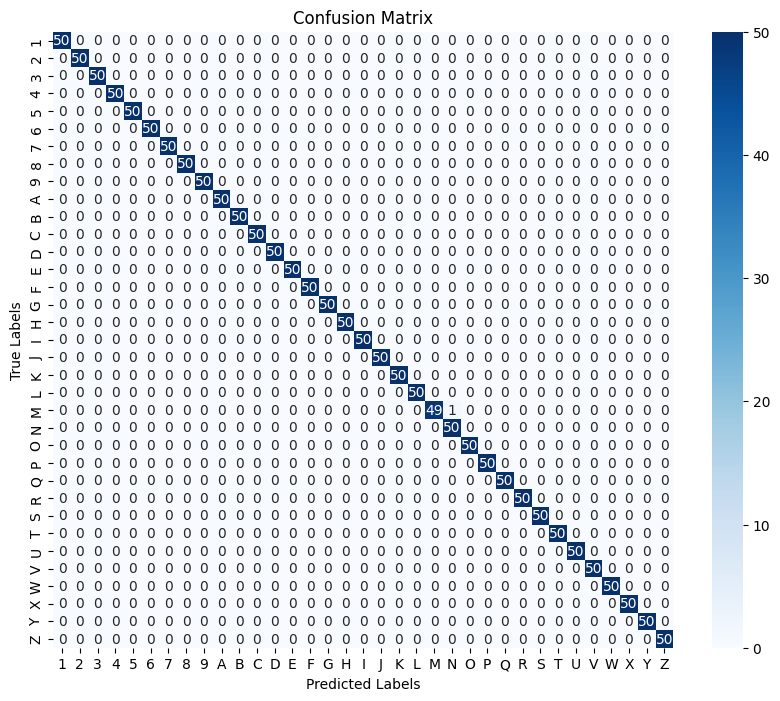

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 390ms/step


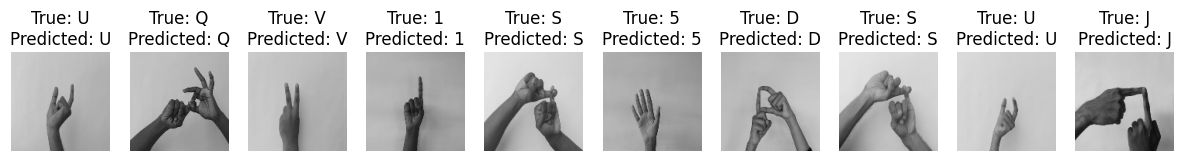

In [ ]:
import random

# Reset test generator to start from the beginning
test_generator.reset()
#print(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
# Get a batch of test data
batch = test_generator.next()

# Extract images and labels from the batch
images, labels = batch

# Randomly select a subset of images and their corresponding labels
num_images_to_display = 10  # Adjust the number of images to display
random_indices = random.sample(range(len(images)), num_images_to_display)
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# Make predictions on the selected images
predictions = cnn_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display images with their predicted and true classes
plt.figure(figsize=(15, 3 * num_images_to_display))
for i in range(num_images_to_display):
    # Display the image
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(selected_images[i])

    # Get the true and predicted class names
    true_class = class_names[np.argmax(selected_labels[i])]
    pred_class = class_names[predicted_classes[i]]

    # Set the title with true and predicted classes
    plt.title(f'True: {true_class}\nPredicted: {pred_class}')
    plt.axis('off')

plt.show()

# INCEPTIONV3

In [ ]:
from tensorflow.keras.applications import InceptionV3
# Load the  inceptionv3 model pre-trained on ImageNet without the top layer
base_model1 = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the convolutional layers
base_model1.trainable = False

# Print model summary
base_model1.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 63, 63, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 63, 63, 32)           96        ['conv2d_6[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     (None, 63, 63, 32)           0         ['batch_normalizati

In [ ]:

inceptionv3_model = models.Sequential([
    base_model1,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(35, activation='softmax')
])


In [ ]:
inceptionv3_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 35)                17955     
                                                                 
Total params: 26015555 (99.24 MB)
Trainable params: 4212771 (16.07 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [ ]:
# Define parameters
classes = 35
epochs = 10
learning_rate = 0.0001

# Compile the model
inceptionv3_model.compile(optimizer=Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history1 = inceptionv3_model.fit(train_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=validation_generator,
                    shuffle=True)

Epoch 1/10
394/394 [==============================] - 46s 105ms/step - loss: 1.6467 - accuracy: 0.5422 - val_loss: 0.6065 - val_accuracy: 0.8178
Epoch 2/10
394/394 [==============================] - 37s 95ms/step - loss: 0.7463 - accuracy: 0.7686 - val_loss: 0.3793 - val_accuracy: 0.8813
Epoch 3/10
394/394 [==============================] - 38s 97ms/step - loss: 0.5505 - accuracy: 0.8244 - val_loss: 0.3134 - val_accuracy: 0.9076
Epoch 4/10
394/394 [==============================] - 40s 102ms/step - loss: 0.4779 - accuracy: 0.8434 - val_loss: 0.2832 - val_accuracy: 0.9083
Epoch 5/10
394/394 [==============================] - 40s 101ms/step - loss: 0.4211 - accuracy: 0.8628 - val_loss: 0.2381 - val_accuracy: 0.9225
Epoch 6/10
394/394 [==============================] - 40s 101ms/step - loss: 0.3938 - accuracy: 0.8703 - val_loss: 0.2035 - val_accuracy: 0.9330
Epoch 7/10
394/394 [==============================] - 40s 102ms/step - loss: 0.3413 - accuracy: 0.8867 - val_loss: 0.1845 - val_accu

In [ ]:
inceptionv3_model.save('custom-inceptionv3-newisl.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


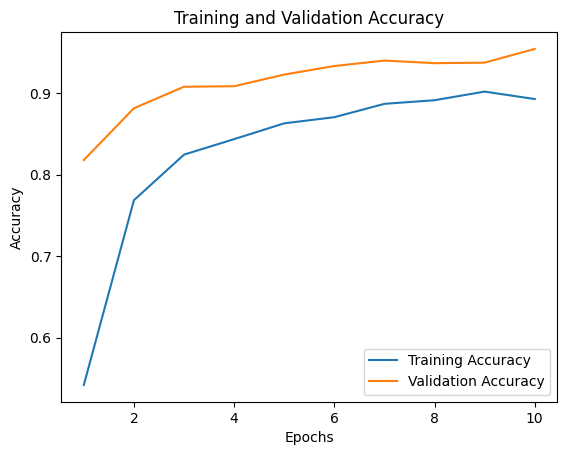

In [ ]:
import matplotlib.pyplot as plt
# Extract training and validation accuracy and loss from history
train_accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

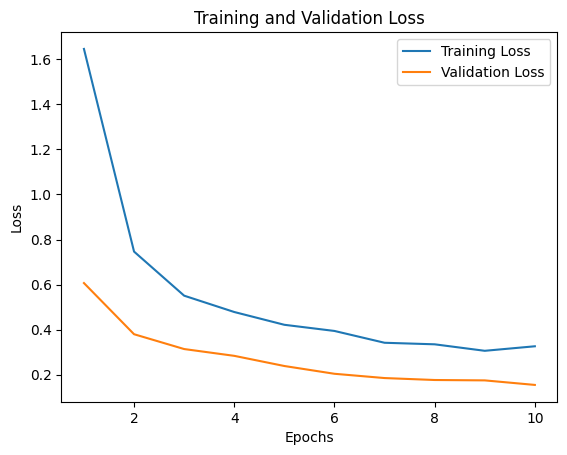

In [ ]:

# Plot training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Generate predictions on test data
predictions = inceptionv3_model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels back to categorical labels
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)*100
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')*100
recall = recall_score(true_classes, predicted_classes, average='weighted')*100
f1_score = 2 * (precision * recall) / (precision + recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


55/55 [==============================] - 3s 48ms/step
Accuracy: 98.05714285714285
Precision: 98.29877913429522
Recall: 98.05714285714285
F1-score: 98.17781231649957


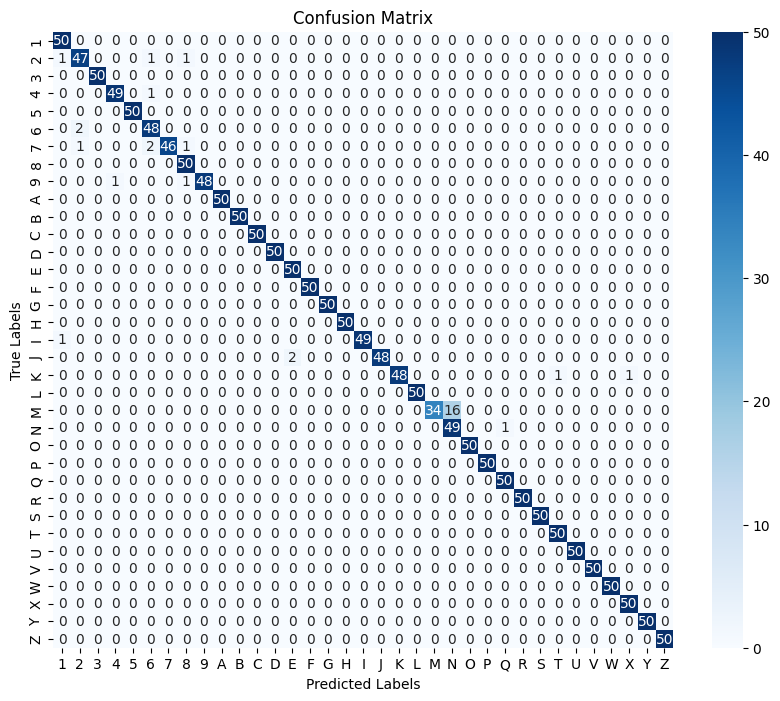

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 2s 2s/step


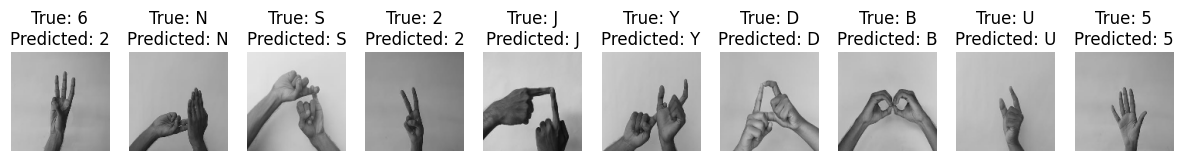

In [ ]:
import random

# Reset test generator to start from the beginning
test_generator.reset()
#print(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
# Get a batch of test data
batch = test_generator.next()

# Extract images and labels from the batch
images, labels = batch

# Randomly select a subset of images and their corresponding labels
num_images_to_display = 10  # Adjust the number of images to display
random_indices = random.sample(range(len(images)), num_images_to_display)
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# Make predictions on the selected images
predictions = inceptionv3_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display images with their predicted and true classes
plt.figure(figsize=(15, 3 * num_images_to_display))
for i in range(num_images_to_display):
    # Display the image
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(selected_images[i])

    # Get the true and predicted class names
    true_class = class_names[np.argmax(selected_labels[i])]
    pred_class = class_names[predicted_classes[i]]

    # Set the title with true and predicted classes
    plt.title(f'True: {true_class}\nPredicted: {pred_class}')
    plt.axis('off')

plt.show()

# MOBILENETV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
# Load the MobileNetV2 model pre-trained on ImageNet without the top layer
base_model2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# Freeze the convolutional layers
base_model2.trainable = False
# Print model summary
base_model2.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[

In [ ]:
MobileNetV2_model = models.Sequential([
    base_model2,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(35, activation='softmax')
])


In [ ]:
MobileNetV2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_2 (Flatten)         (None, 20480)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               10486272  
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 35)                17955     
                                                                 
Total params: 12762211 (48.68 MB)
Trainable params: 10504227 (40.07 MB)
Non-trainable params: 2257984 (8.61 MB)
________

In [ ]:
# Define parameters
classes = 35
epochs = 10
learning_rate = 0.0001

# Compile the model
MobileNetV2_model.compile(optimizer=Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history2 = MobileNetV2_model.fit(train_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=validation_generator,
                    shuffle=True)

Epoch 1/10
394/394 [==============================] - 41s 97ms/step - loss: 0.8389 - accuracy: 0.7590 - val_loss: 0.1611 - val_accuracy: 0.9441
Epoch 2/10
394/394 [==============================] - 38s 96ms/step - loss: 0.2495 - accuracy: 0.9197 - val_loss: 0.0810 - val_accuracy: 0.9743
Epoch 3/10
394/394 [==============================] - 39s 99ms/step - loss: 0.1756 - accuracy: 0.9410 - val_loss: 0.0768 - val_accuracy: 0.9762
Epoch 4/10
394/394 [==============================] - 40s 100ms/step - loss: 0.1448 - accuracy: 0.9513 - val_loss: 0.0611 - val_accuracy: 0.9806
Epoch 5/10
394/394 [==============================] - 40s 101ms/step - loss: 0.1390 - accuracy: 0.9525 - val_loss: 0.0405 - val_accuracy: 0.9876
Epoch 6/10
394/394 [==============================] - 39s 100ms/step - loss: 0.1168 - accuracy: 0.9602 - val_loss: 0.0425 - val_accuracy: 0.9829
Epoch 7/10
394/394 [==============================] - 41s 103ms/step - loss: 0.1068 - accuracy: 0.9650 - val_loss: 0.0718 - val_accur

In [ ]:
MobileNetV2_model.save('custom-mobilenetv2-newisl.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


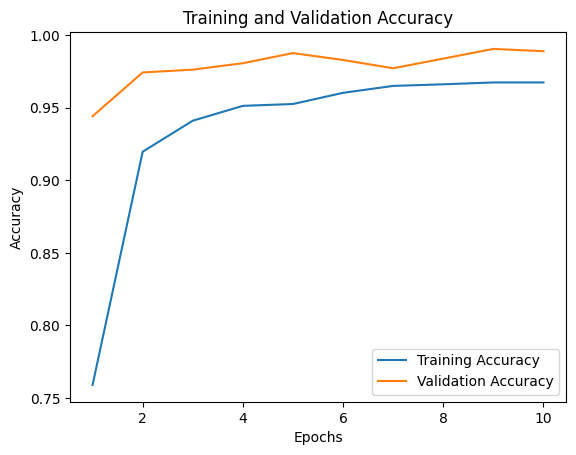

In [ ]:
import matplotlib.pyplot as plt
# Extract training and validation accuracy and loss from history
train_accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


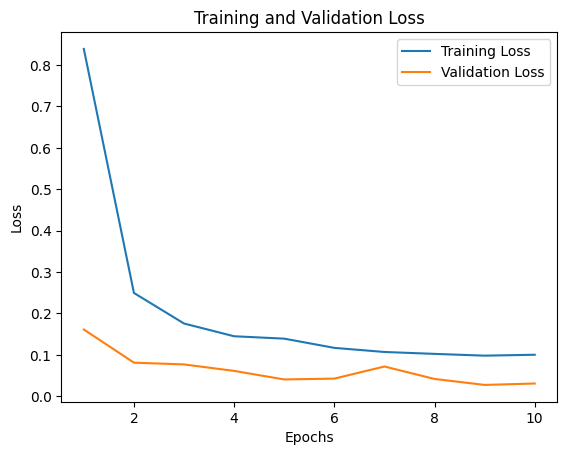

In [ ]:

# Plot training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Generate predictions on test data
predictions = MobileNetV2_model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels back to categorical labels
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)*100
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')*100
recall = recall_score(true_classes, predicted_classes, average='weighted')*100
f1_score = 2 * (precision * recall) / (precision + recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


55/55 [==============================] - 2s 17ms/step
Accuracy: 97.25714285714285
Precision: 97.69800998499855
Recall: 97.25714285714285
F1-score: 97.47707793764621


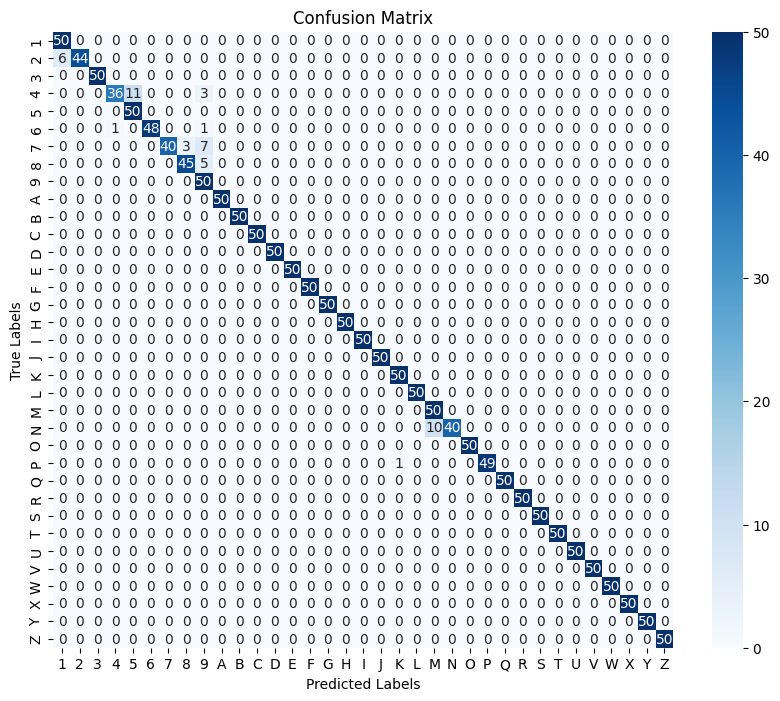

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 22ms/step


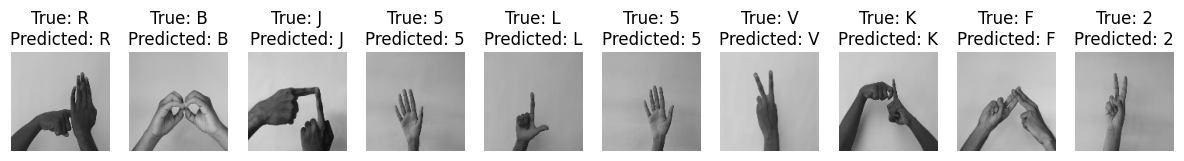

In [ ]:
import random

# Reset test generator to start from the beginning
test_generator.reset()
#print(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
# Get a batch of test data
batch = test_generator.next()

# Extract images and labels from the batch
images, labels = batch

# Randomly select a subset of images and their corresponding labels
num_images_to_display = 10  # Adjust the number of images to display
random_indices = random.sample(range(len(images)), num_images_to_display)
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# Make predictions on the selected images
predictions = inceptionv3_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display images with their predicted and true classes
plt.figure(figsize=(15, 3 * num_images_to_display))
for i in range(num_images_to_display):
    # Display the image
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(selected_images[i])

    # Get the true and predicted class names
    true_class = class_names[np.argmax(selected_labels[i])]
    pred_class = class_names[predicted_classes[i]]

    # Set the title with true and predicted classes
    plt.title(f'True: {true_class}\nPredicted: {pred_class}')
    plt.axis('off')

plt.show()

# RESNET50V2


In [ ]:
from tensorflow.keras.applications import ResNet50V2
# Load the ResNet50 model pre-trained on ImageNet without the top layer
base_model3 = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# Freeze the convolutional layers
base_model3.trainable = False
# Print model summary
base_model3.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 66, 66, 64)           0         ['conv1_conv[0][0]']          
                                                                                         

In [ ]:
ResNet50V2_model = models.Sequential([
    base_model3,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(35, activation='softmax')
])

In [ ]:
ResNet50V2_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               16777728  
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 35)                17955     
                                                                 
Total params: 40360483 (153.96 MB)
Trainable params: 16795683 (64.07 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
# Define parameters
classes = 35
epochs = 10
learning_rate = 0.0001

# Compile the model
ResNet50V2_model.compile(optimizer=Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history3 = ResNet50V2_model.fit(train_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=validation_generator,
                    shuffle=True)

Epoch 1/10
394/394 [==============================] - 41s 98ms/step - loss: 1.2992 - accuracy: 0.6640 - val_loss: 0.3535 - val_accuracy: 0.8829
Epoch 2/10
394/394 [==============================] - 39s 98ms/step - loss: 0.5309 - accuracy: 0.8315 - val_loss: 0.2344 - val_accuracy: 0.9184
Epoch 3/10
394/394 [==============================] - 40s 102ms/step - loss: 0.4215 - accuracy: 0.8640 - val_loss: 0.1581 - val_accuracy: 0.9419
Epoch 4/10
394/394 [==============================] - 40s 102ms/step - loss: 0.3506 - accuracy: 0.8862 - val_loss: 0.1334 - val_accuracy: 0.9514
Epoch 5/10
394/394 [==============================] - 40s 102ms/step - loss: 0.3191 - accuracy: 0.9005 - val_loss: 0.1317 - val_accuracy: 0.9549
Epoch 6/10
394/394 [==============================] - 40s 102ms/step - loss: 0.2989 - accuracy: 0.9052 - val_loss: 0.1137 - val_accuracy: 0.9603
Epoch 7/10
394/394 [==============================] - 40s 101ms/step - loss: 0.2493 - accuracy: 0.9211 - val_loss: 0.1276 - val_accu

In [ ]:
ResNet50V2_model.save('custom-resnet50v2-newisl.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


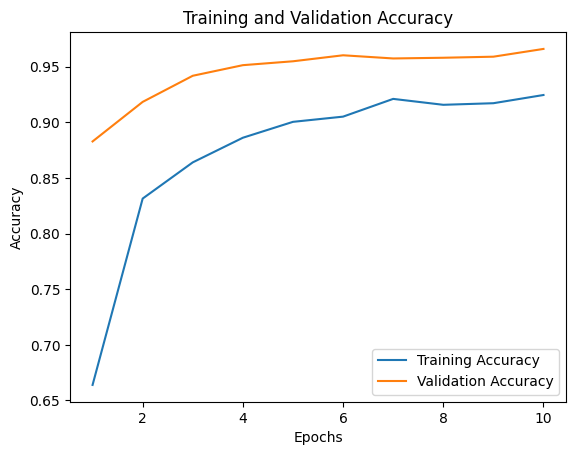

In [ ]:
import matplotlib.pyplot as plt
# Extract training and validation accuracy and loss from history
train_accuracy = history3.history['accuracy']
val_accuracy = history3.history['val_accuracy']
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


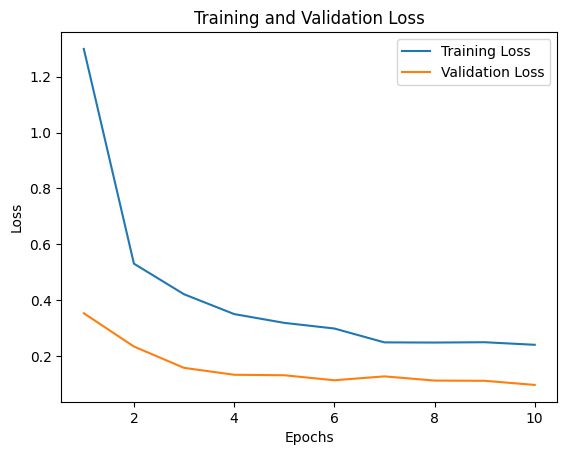

In [ ]:

# Plot training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Generate predictions on test data
predictions = ResNet50V2_model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels back to categorical labels
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)*100
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')*100
recall = recall_score(true_classes, predicted_classes, average='weighted')*100
f1_score = 2 * (precision * recall) / (precision + recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


55/55 [==============================] - 3s 38ms/step
Accuracy: 98.11428571428571
Precision: 98.28891502405858
Recall: 98.11428571428571
F1-score: 98.20152273450091


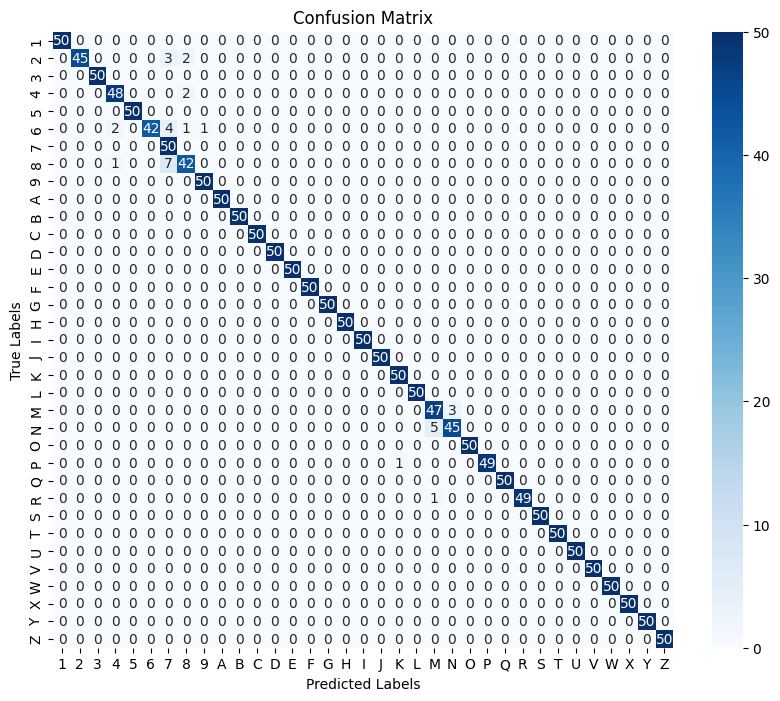

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 1s 1s/step


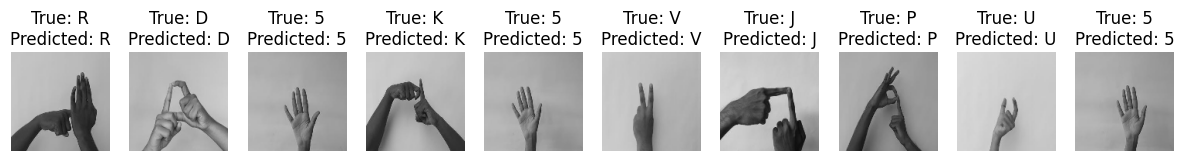

In [ ]:
import random

# Reset test generator to start from the beginning
test_generator.reset()
#print(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
# Get a batch of test data
batch = test_generator.next()

# Extract images and labels from the batch
images, labels = batch

# Randomly select a subset of images and their corresponding labels
num_images_to_display = 10  # Adjust the number of images to display
random_indices = random.sample(range(len(images)), num_images_to_display)
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# Make predictions on the selected images
predictions = ResNet50V2_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display images with their predicted and true classes
plt.figure(figsize=(15, 3 * num_images_to_display))
for i in range(num_images_to_display):
    # Display the image
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(selected_images[i])

    # Get the true and predicted class names
    true_class = class_names[np.argmax(selected_labels[i])]
    pred_class = class_names[predicted_classes[i]]

    # Set the title with true and predicted classes
    plt.title(f'True: {true_class}\nPredicted: {pred_class}')
    plt.axis('off')

plt.show()

# VGG19

In [ ]:
from tensorflow.keras.applications import VGG19
# Load the vgg19 model pre-trained on ImageNet without the top layer
base_model4 = VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# Freeze the convolutional layers
base_model4.trainable = False
# Print model summary
base_model4.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
VGG19_model = models.Sequential([
    base_model4,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(35, activation='softmax')
])

In [ ]:
VGG19_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 35)                17955     
                                                                 
Total params: 24237155 (92.46 MB)
Trainable params: 4212771 (16.07 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [ ]:
# Define parameters
classes = 35
epochs = 10
learning_rate = 0.0001

# Compile the model
VGG19_model.compile(optimizer=Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history4 = VGG19_model.fit(train_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=validation_generator,
                    shuffle=True)

Epoch 1/10
394/394 [==============================] - 44s 104ms/step - loss: 2.1937 - accuracy: 0.4187 - val_loss: 1.1340 - val_accuracy: 0.7762
Epoch 2/10
394/394 [==============================] - 42s 106ms/step - loss: 1.0846 - accuracy: 0.7062 - val_loss: 0.6743 - val_accuracy: 0.8717
Epoch 3/10
394/394 [==============================] - 45s 114ms/step - loss: 0.7685 - accuracy: 0.7874 - val_loss: 0.5180 - val_accuracy: 0.8816
Epoch 4/10
394/394 [==============================] - 42s 106ms/step - loss: 0.6107 - accuracy: 0.8282 - val_loss: 0.4033 - val_accuracy: 0.9178
Epoch 5/10
394/394 [==============================] - 42s 105ms/step - loss: 0.5017 - accuracy: 0.8555 - val_loss: 0.3481 - val_accuracy: 0.9260
Epoch 6/10
394/394 [==============================] - 41s 105ms/step - loss: 0.4340 - accuracy: 0.8763 - val_loss: 0.2859 - val_accuracy: 0.9444
Epoch 7/10
394/394 [==============================] - 42s 106ms/step - loss: 0.3827 - accuracy: 0.8883 - val_loss: 0.2490 - val_ac

In [ ]:
VGG19_model.save('custom-vgg19-newisl.h5')

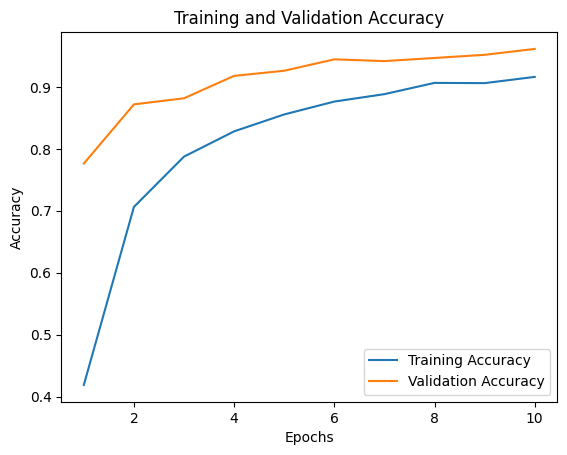

In [ ]:
import matplotlib.pyplot as plt
# Extract training and validation accuracy and loss from history
train_accuracy = history4.history['accuracy']
val_accuracy = history4.history['val_accuracy']
train_loss = history4.history['loss']
val_loss = history4.history['val_loss']

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


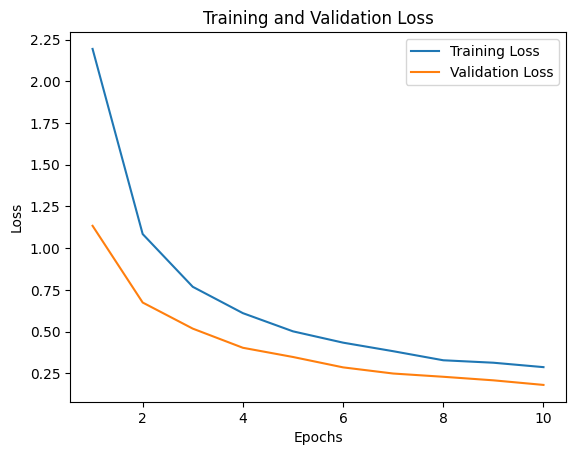

In [ ]:

# Plot training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Generate predictions on test data
predictions = VGG19_model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels back to categorical labels
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)*100
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')*100
recall = recall_score(true_classes, predicted_classes, average='weighted')*100
f1_score = 2 * (precision * recall) / (precision + recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


55/55 [==============================] - 5s 94ms/step
Accuracy: 95.88571428571429
Precision: 96.78975205824997
Recall: 95.88571428571429
F1-score: 96.33561228884717


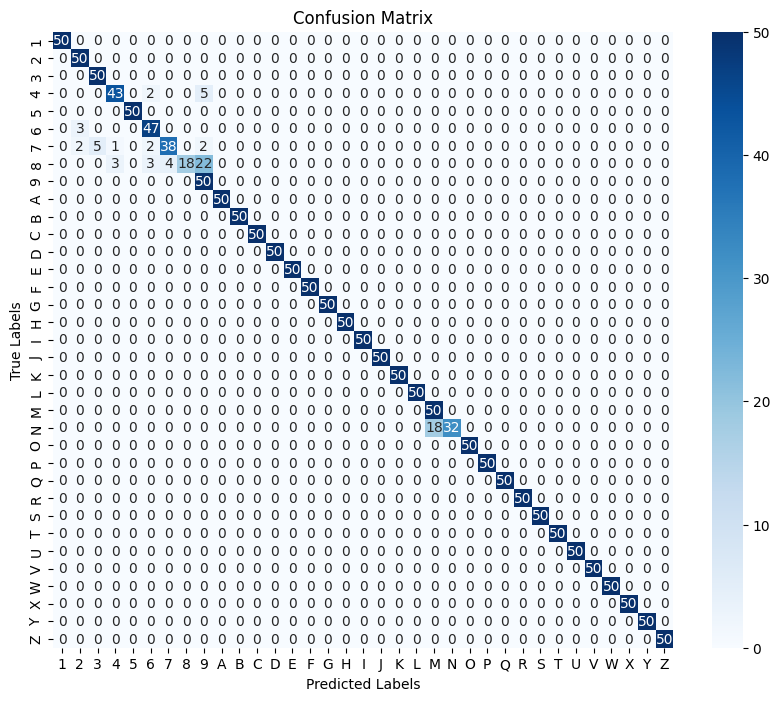

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 1s 1s/step


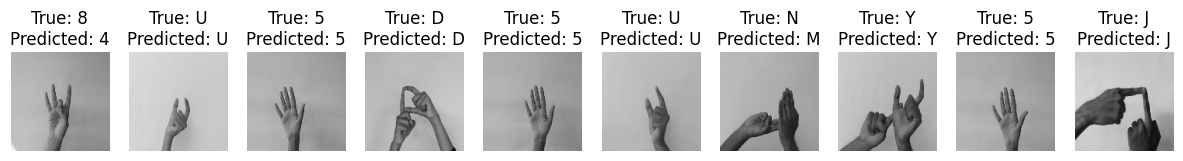

In [ ]:
import random

# Reset test generator to start from the beginning
test_generator.reset()
#print(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
# Get a batch of test data
batch = test_generator.next()

# Extract images and labels from the batch
images, labels = batch

# Randomly select a subset of images and their corresponding labels
num_images_to_display = 10  # Adjust the number of images to display
random_indices = random.sample(range(len(images)), num_images_to_display)
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# Make predictions on the selected images
predictions = VGG19_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display images with their predicted and true classes
plt.figure(figsize=(15, 3 * num_images_to_display))
for i in range(num_images_to_display):
    # Display the image
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(selected_images[i])

    # Get the true and predicted class names
    true_class = class_names[np.argmax(selected_labels[i])]
    pred_class = class_names[predicted_classes[i]]

    # Set the title with true and predicted classes
    plt.title(f'True: {true_class}\nPredicted: {pred_class}')
    plt.axis('off')

plt.show()

# MODEL COMPARISON

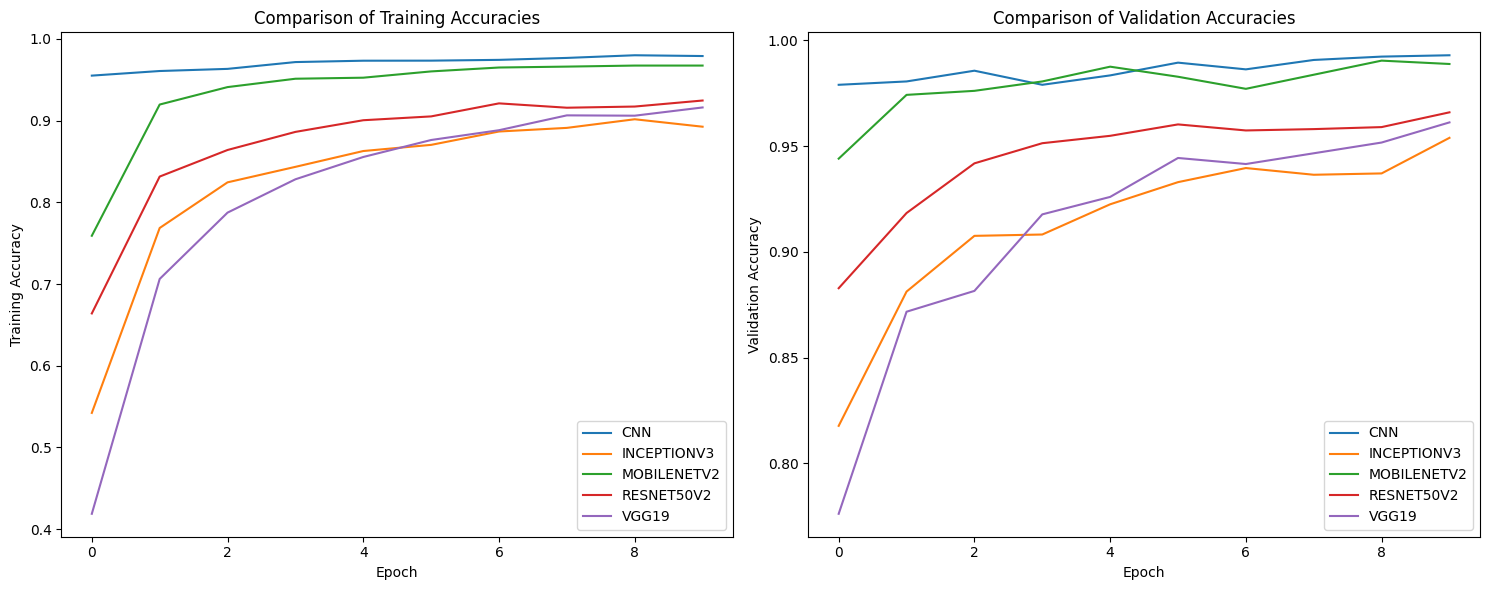

In [ ]:
import matplotlib.pyplot as plt

# Dictionary to store accuracies
train_accuracies = {}
validation_accuracies = {}

# Extract accuracies from history objects
train_accuracies['CNN'] = history.history['accuracy']
train_accuracies['INCEPTIONV3'] = history1.history['accuracy']
train_accuracies['MOBILENETV2'] = history2.history['accuracy']
train_accuracies['RESNET50V2'] = history3.history['accuracy']
train_accuracies['VGG19'] = history4.history['accuracy']

validation_accuracies['CNN'] = history.history['val_accuracy']
validation_accuracies['INCEPTIONV3'] = history1.history['val_accuracy']
validation_accuracies['MOBILENETV2'] = history2.history['val_accuracy']
validation_accuracies['RESNET50V2'] = history3.history['val_accuracy']
validation_accuracies['VGG19'] = history4.history['val_accuracy']

# Plotting the accuracies
plt.figure(figsize=(15, 6))

# Plot training accuracies
plt.subplot(1, 2, 1)
for model, acc in train_accuracies.items():
    plt.plot(acc, label=model)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Comparison of Training Accuracies')
plt.legend()

# Plot validation accuracies
plt.subplot(1, 2, 2)
for model, acc in validation_accuracies.items():
    plt.plot(acc, label=model)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Validation Accuracies')
plt.legend()

plt.tight_layout()
plt.show()


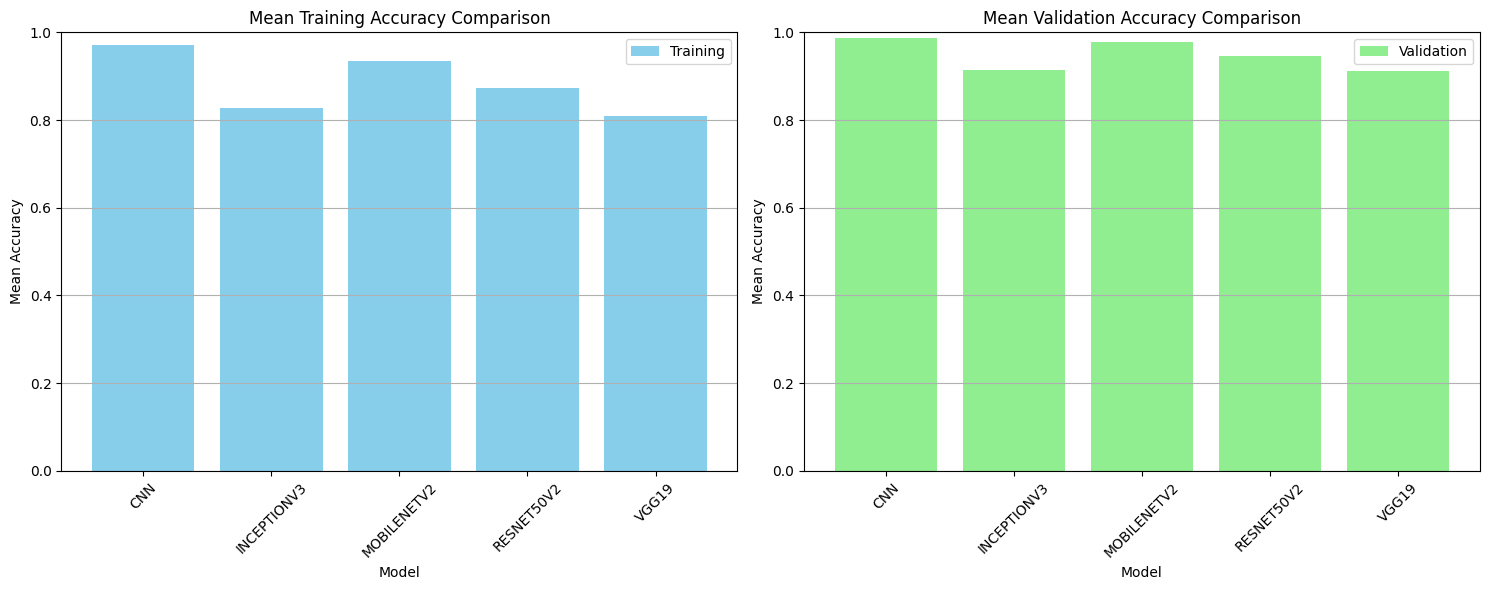

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dictionary to store accuracies
train_accuracies = {}
validation_accuracies = {}

# Extract accuracies from history objects
train_accuracies['CNN'] = history.history['accuracy']
train_accuracies['INCEPTIONV3'] = history1.history['accuracy']
train_accuracies['MOBILENETV2'] = history2.history['accuracy']
train_accuracies['RESNET50V2'] = history3.history['accuracy']
train_accuracies['VGG19'] = history4.history['accuracy']

validation_accuracies['CNN'] = history.history['val_accuracy']
validation_accuracies['INCEPTIONV3'] = history1.history['val_accuracy']
validation_accuracies['MOBILENETV2'] = history2.history['val_accuracy']
validation_accuracies['RESNET50V2'] = history3.history['val_accuracy']
validation_accuracies['VGG19'] = history4.history['val_accuracy']

# Calculate mean accuracies
train_means = [np.mean(acc) for acc in train_accuracies.values()]
validation_means = [np.mean(acc) for acc in validation_accuracies.values()]

# Plotting bar plots for mean training and validation accuracies
plt.figure(figsize=(15, 6))

# Plot mean training accuracies
plt.subplot(1, 2, 1)
plt.bar(np.arange(len(train_accuracies)), train_means, color='skyblue', label='Training')
plt.xlabel('Model')
plt.ylabel('Mean Accuracy')
plt.title('Mean Training Accuracy Comparison')
plt.xticks(np.arange(len(train_accuracies)), train_accuracies.keys(), rotation=45)
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y')

# Plot mean validation accuracies
plt.subplot(1, 2, 2)
plt.bar(np.arange(len(validation_accuracies)), validation_means, color='lightgreen', label='Validation')
plt.xlabel('Model')
plt.ylabel('Mean Accuracy')
plt.title('Mean Validation Accuracy Comparison')
plt.xticks(np.arange(len(validation_accuracies)), validation_accuracies.keys(), rotation=45)
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y')

plt.tight_layout()
plt.show()


55/55 [==============================] - 3s 53ms/step - loss: 0.1291 - accuracy: 0.9589


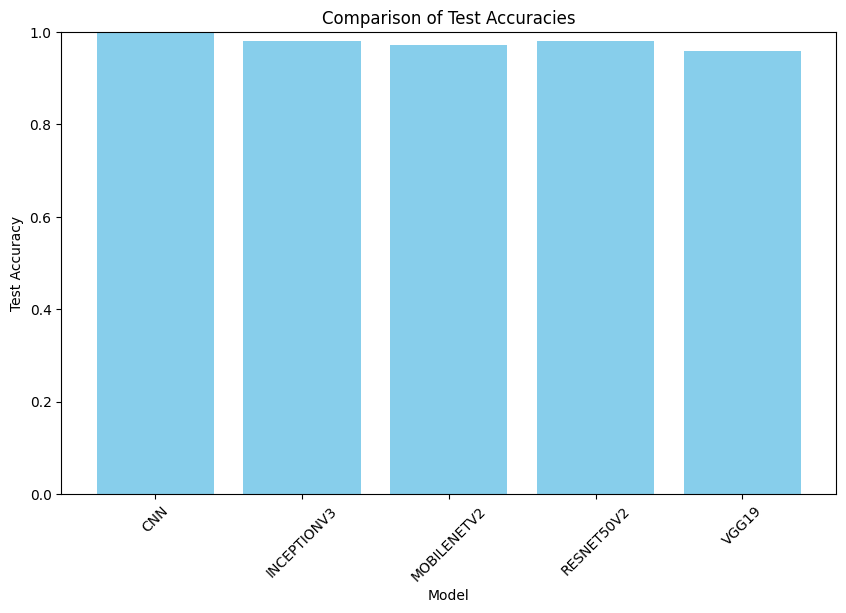

In [ ]:
# Dictionary to store test accuracies
test_accuracies = {}

# Evaluate each model on the test data
test_accuracies['CNN'] = cnn_model.evaluate(test_generator)[1]
test_accuracies['INCEPTIONV3'] = inceptionv3_model.evaluate(test_generator)[1]
test_accuracies['MOBILENETV2'] = MobileNetV2_model.evaluate(test_generator)[1]
test_accuracies['RESNET50V2'] = ResNet50V2_model.evaluate(test_generator)[1]
test_accuracies['VGG19'] = VGG19_model.evaluate(test_generator)[1]

# Plotting the test accuracies
plt.figure(figsize=(10, 6))
plt.bar(test_accuracies.keys(), test_accuracies.values(), color='skyblue')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Comparison of Test Accuracies')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.show()
